In [271]:
import matplotlib.pyplot as plt
from matplotlib import mlab
import numpy as np
import scipy.io.wavfile
import scipy.signal
from IPython.display import Audio

In [2]:
letters = np.empty((4, 26, 20), dtype=object)
for i, j, k in np.ndindex(letters.shape):
    subject = i + 1
    letter = chr(ord("A") + j)
    fs, x = scipy.io.wavfile.read(f"letters/{subject}/{letter}/PZ/{k}.wav")
    letters[i, j, k] = x

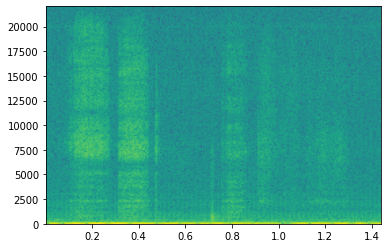

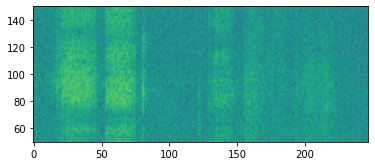

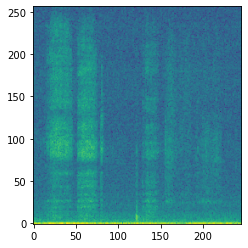

(257, 247)


In [341]:
display(Audio(letters[0,0,0], rate=fs))
X, *_ = plt.specgram(letters[0,0,0], Fs=fs, NFFT=512, noverlap=256)
D = np.abs(np.diff(X, axis=1))
plt.show()
plt.imshow(np.log10(X), origin='lower')
plt.ylim(50, 150)
plt.show()
plt.imshow(np.log10(np.abs(D)), origin='lower')
plt.show()
print(X.shape)

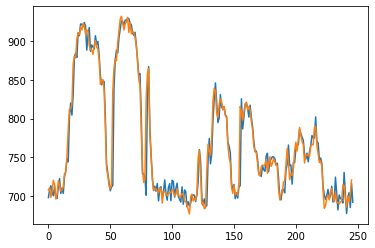

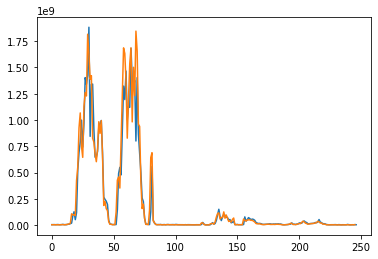

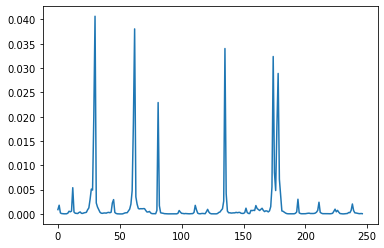

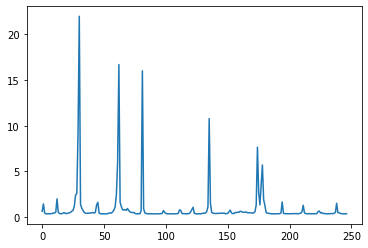

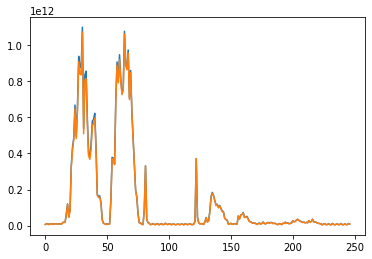

In [87]:
plt.plot(np.sum(np.log10(X[50:150]), axis=0))
plt.plot(np.sum(np.log10(D[50:150]), axis=0))
plt.show()
flux = np.sqrt(np.sum(np.diff(X[50:150], axis=1)**2, axis=0)) / len(X[50:150])
plt.plot(np.sum(X[50:150], axis=0) / 500)
plt.plot(flux)
plt.show()
flat = np.exp(np.sum(np.log(X), axis=0)/len(X)) / (np.sum(X, axis=0)/len(X))
plt.plot(flat)
plt.show()
centroid = np.sum(np.arange(len(X))[:, None] * X, axis=0) / np.sum(X, axis=0)
plt.plot(centroid)
plt.show()
power = np.sum(X[10:], axis=0) # / len(X[10:])
plt.plot(power)
power2 = np.sum(X[10:200], axis=0) # / len(X[50:150])
plt.plot(power2)

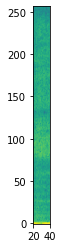

(257, 20) (257, 247) (228,)


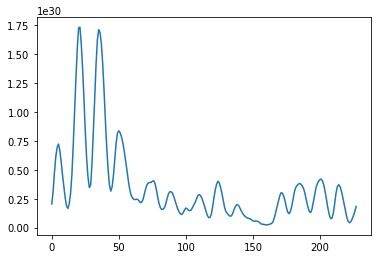

In [125]:
start, end = 20, 40
plt.imshow(np.log10(X), origin='lower')
plt.xlim(start, end)
plt.show()

crop = X[:, start:end]
corr = scipy.signal.correlate(X, crop, mode='valid')[0]
plt.plot(corr)
print(crop.shape, X.shape, corr.shape)
plt.show()

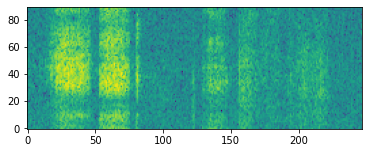

In [127]:
crop = X[50:140]
plt.imshow(np.log10(crop), origin='lower')
plt.show()

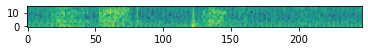

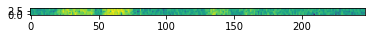

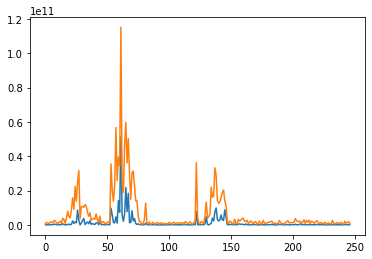

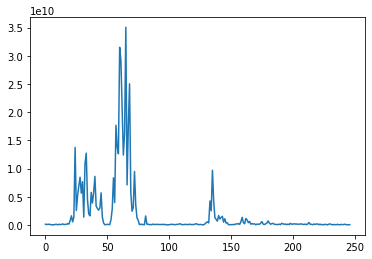

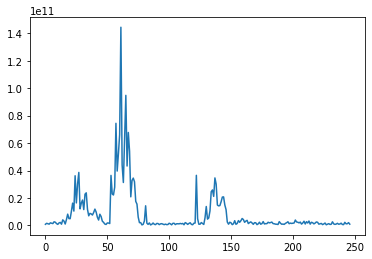

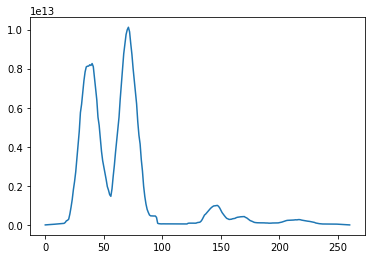

In [220]:
# These frequency ranges seem to be especially useful for separating stroke noise from paper noise:
plt.imshow(np.log(X[10:25]), origin='lower')
plt.show()

plt.imshow(np.log(X[180:185]), origin='lower')
plt.show()

plt.plot(X[20])
plt.plot(np.sum(X[15:25], axis=0))
plt.show()
plt.plot(np.sum(X[180:185], axis=0))
plt.show()
plt.plot(np.sum(X[15:25], axis=0) + np.sum(X[180:185], axis=0))
plt.show()

plt.plot(np.convolve(np.sum(X[20:140], axis=0), np.ones(15)))
plt.show()

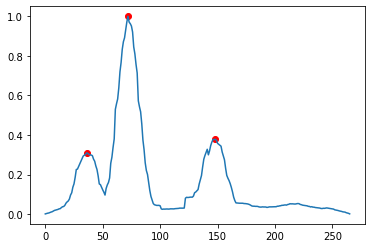

In [270]:
summed = np.sum(X[15:25], axis=0)
smoothed = np.convolve(summed, np.ones(20))
smoothed /= np.max(smoothed)
plt.plot(smoothed)
peaks, info = scipy.signal.find_peaks(smoothed, height=0.2, distance=10)
plt.scatter(peaks, smoothed[peaks], c='red')

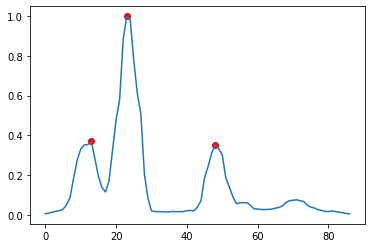

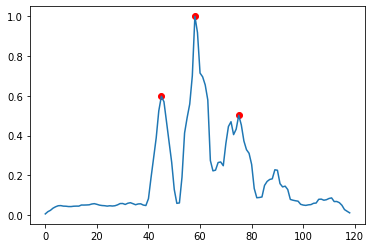

array([[0.        , 0.59709213],
       [0.07546485, 1.        ],
       [0.17414966, 0.50169008]])

In [450]:
%matplotlib inline
def filter_transients(x, n):
    return np.min(x[:len(x)//n*n].reshape((-1, n)), axis=1)

def find_strokes(x, fs, verbose=False):
    X, freqs, t = mlab.specgram(x, Fs=fs, NFFT=512, noverlap=256)
    summed = np.sum(X[15:30], axis=0)
    filtered = filter_transients(summed, 3)
#     summed = np.sum(X[50:100], axis=0)
    smoothed = np.convolve(filtered, np.ones(6))
    smoothed /= np.max(smoothed)
    peaks, info = scipy.signal.find_peaks(smoothed, height=0.2, prominence=0.15, distance=10)
    amp = info["peak_heights"]
    if verbose:
        plt.plot(smoothed)
        plt.scatter(peaks, amp, c='red')
        plt.show()
    times = t[peaks]
    # Matrix of [[stroke time, stroke amplitude]]
    return np.vstack((times - times[0], amp)).T

find_strokes(letters[0,0,0], fs, verbose=True)
# [0, 17, 16] was registering too many peaks due to not specifying NFFT, noverlap in find_strokes.
# [1, 1, 12] has severe paper noise and duplicate peaks (added prominence=0.1).
# [1, 1, 18] had bad non-stroke noise issues and some very high transients.
find_strokes(letters[1, 1, 18], fs, verbose=True)

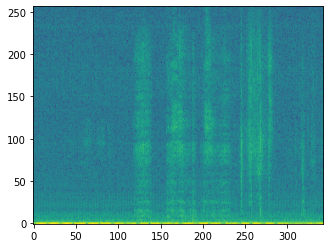

(257, 343)


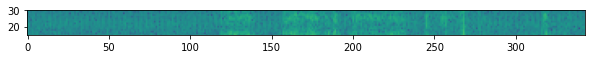

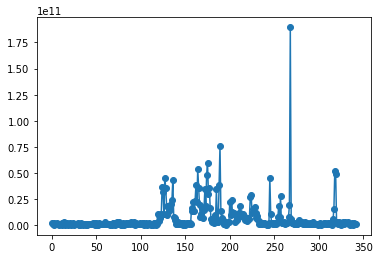

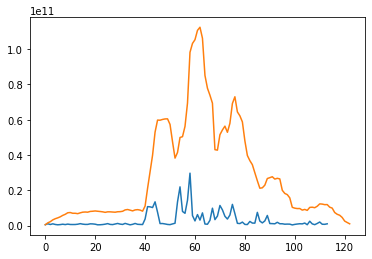

In [435]:
display(Audio(letters[1, 1, 18], rate=fs))
X, *_ = mlab.specgram(letters[1, 1, 18], Fs=fs, NFFT=512, noverlap=256)
plt.imshow(np.log(X), origin='lower')
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(np.log(X), origin='lower')
plt.ylim(15, 30)
print(X.shape)
plt.show()
cropped = np.sum(X[15:30], axis=0)
plt.figure()
plt.plot(cropped)
plt.scatter(np.arange(len(cropped)), cropped)
plt.show()
plt.figure()
filtered = filter_transients(cropped, 3)
plt.plot(filtered)
plt.plot(np.convolve(filtered, np.ones(10)))
plt.show()
# plt.plot(np.convolve(np.sum(X[15:30], axis=0), np.ones(20)/20))

In [451]:
strokes = np.empty(letters.shape, dtype=object)
for i in np.ndindex(letters.shape):
    strokes[i] = find_strokes(letters[i], fs)

In [452]:
def nearest_neighbor(x, train):
    best = None
    for i, y in np.ndenumerate(train):
        # NOTE: If the number of strokes does not match, this dismisses the match completely.
        if len(x) != len(y):
            continue
        dist = np.linalg.norm(x - y, axis=1).sum()
#         print(best, dist)
        if best is None or dist < best[1]:
            best = (i, dist)
    return best[0]

In [462]:
def eval_accuracy(test, train):
    results = []
    for i, x in np.ndenumerate(test):
    #     print(i, x, len(x))
        results.append((i, nearest_neighbor(x, train)))
    results = np.array(results)
    return np.mean(results[:, 0, 1] == results[:, 1, 1])

test = strokes[:, :, 15:]
train = strokes[:, :, :15]
print(f"With all subjects in training data: {round(eval_accuracy(test, train) * 100, 2)}%")
for subject in range(len(strokes)):
    test = strokes[subject][None]
    train = np.vstack((strokes[:subject], strokes[subject+1:]))
    print(f"Subject {subject}: {round(eval_accuracy(test, train) * 100, 2)}%")

With all subjects in training data: 15.19%
Subject 0: 10.0%
Subject 1: 12.12%
Subject 2: 10.0%
Subject 3: 8.08%


R


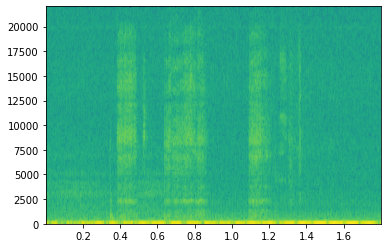

In [307]:
display(Audio(letters[0, 17, 16], rate=fs))
plt.specgram(letters[0, 17, 16], Fs=fs)
print(chr(ord("A") + 17))
plt.show()

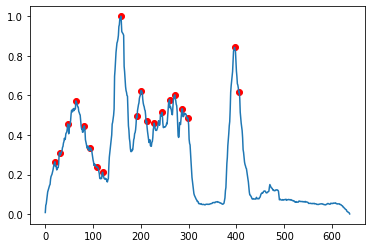

array([[0.        , 0.26448265],
       [0.02902494, 0.31095646],
       [0.07836735, 0.45574583],
       [0.12770975, 0.57229054],
       [0.17995465, 0.4458466 ],
       [0.21478458, 0.33557136],
       [0.2554195 , 0.23929888],
       [0.29024943, 0.21150808],
       [0.40054422, 1.        ],
       [0.49632653, 0.49763826],
       [0.52535147, 0.62466186],
       [0.55727891, 0.47141984],
       [0.60371882, 0.45934483],
       [0.65015873, 0.51374012],
       [0.69659864, 0.57820662],
       [0.72852608, 0.6025124 ],
       [0.77206349, 0.53234471],
       [0.80689342, 0.48678794],
       [1.09133787, 0.84248323],
       [1.12036281, 0.61935094]])

In [310]:
find_strokes(letters[0, 17, 16], fs, verbose=True)

(1675800, 2) int32
(88200, 2) int32


/tmp/ipykernel_35471/3015389952.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, x = scipy.io.wavfile.read("letter_runs/1-A-SM.wav")


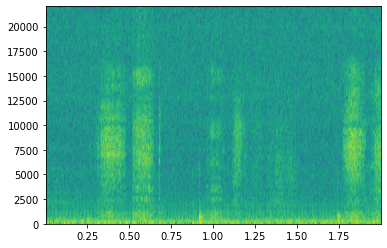

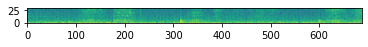

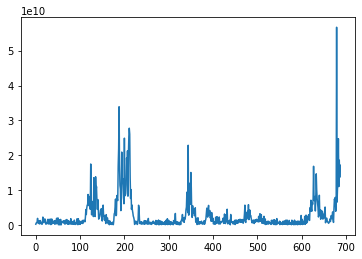

In [208]:
fs, x = scipy.io.wavfile.read("letter_runs/1-A-SM.wav")
print(x.shape, x.dtype)
x = x[:fs*2]
# x = x[int(fs*0.75):fs*2:2]
# fs /= 2
print(x.shape, x.dtype)
display(Audio(x[:, 0], rate=fs))
X2, *_ = plt.specgram(x[:, 0], Fs=fs)
plt.show()
plt.imshow(np.log(X2[0:30]), origin='lower')
plt.show()
plt.plot(np.sum(X2[15:25], axis=0))